## Welcome to Jellyfin Movie Recommender

## Imports & Sets

Firstly, we load the all data in csv files. The csv files are representation of a relational database.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
genome_scores_path = r"C:/Users/lunaf/Desktop/Projects/jellyfin-movie-recommender/data/genome-scores.csv"
genome_tags_path = r"C:/Users/lunaf/Desktop/Projects/jellyfin-movie-recommender/data/genome-tags.csv"
links_path = r"C:/Users/lunaf/Desktop/Projects/jellyfin-movie-recommender/data/links.csv"
movies_path = r"C:/Users/lunaf/Desktop/Projects/jellyfin-movie-recommender/data/movies.csv"
ratings_path = r"C:/Users/lunaf/Desktop/Projects/jellyfin-movie-recommender/data/ratings.csv"
tags_path = r"C:/Users/lunaf/Desktop/Projects/jellyfin-movie-recommender/data/tags.csv"

In [3]:
genome_scores_df = pd.read_csv(genome_scores_path)
genome_tags_df = pd.read_csv(genome_tags_path)
links_df = pd.read_csv(links_path)
movies_df = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)
tags_df = pd.read_csv(tags_path)

## Data Preprocessing & EDA

In [4]:
def df_summary(name, df):
    print(f"\n{name}")
    print(df.head())
    print("Shape:", df.shape)
    print(df.describe(include="all"))
    print(df.info())
    print("-" * 40)

datasets = {
    "Genome Scores": genome_scores_df,
    "Genome Tags": genome_tags_df,
    "Links": links_df,
    "Movies": movies_df,
    "Ratings": ratings_df,
    "Tags": tags_df
}

for name, df in datasets.items():
    df_summary(name, df)


Genome Scores
   movieId  tagId  relevance
0        1      1    0.03200
1        1      2    0.02225
2        1      3    0.07000
3        1      4    0.05900
4        1      5    0.12300
Shape: (18472128, 3)
            movieId         tagId     relevance
count  1.847213e+07  1.847213e+07  1.847213e+07
mean   6.421529e+04  5.645000e+02  1.111024e-01
std    7.245929e+04  3.256254e+02  1.499273e-01
min    1.000000e+00  1.000000e+00  2.500000e-04
25%    4.528750e+03  2.827500e+02  2.250000e-02
50%    3.292100e+04  5.645000e+02  5.325000e-02
75%    1.082962e+05  8.462500e+02  1.340000e-01
max    2.881670e+05  1.128000e+03  1.000000e+00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18472128 entries, 0 to 18472127
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 422.8 MB
None
----------------------------------------

Genome Tags
   tagId     

In [6]:
movie_counts = ratings_df.groupby("movieId").size().reset_index(name="rating_count")
movie_counts = movie_counts.merge(movies_df[['movieId','title']], on='movieId')
top_movies = movie_counts.sort_values('rating_count', ascending=False).head(20)

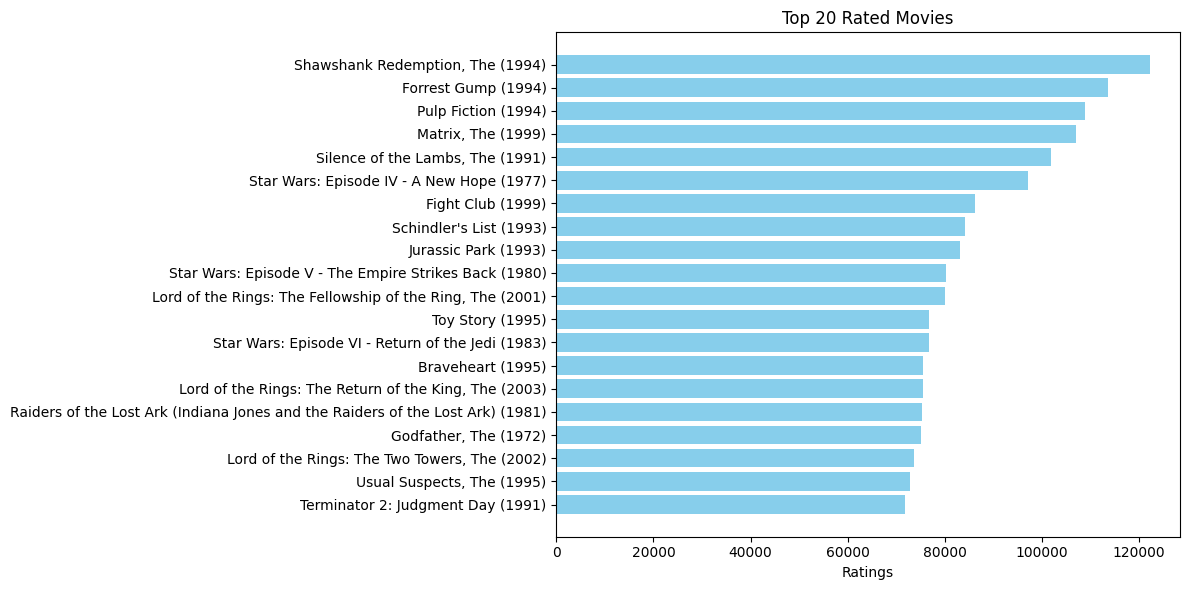

In [8]:
plt.figure(figsize=(12,6))
plt.barh(top_movies['title'][::-1], top_movies['rating_count'][::-1], color='skyblue')
plt.xlabel("Ratings")
plt.title("Top 20 Rated Movies")
plt.tight_layout()
plt.show()

## Feature Engineering

In [9]:
# Merge on movieID
df = movies_df.merge(links_df, on="movieId", how="left")

In [10]:
df.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [12]:
# Genome Scores + Tags merge
genome = genome_scores_df.merge(genome_tags_df, on="tagId")

# Pivot tablo → film x tag
movie_genome_matrix = genome.pivot_table(
    index="movieId",
    columns="tag",
    values="relevance",
    fill_value=0
)

In [13]:
genome.head()

,movieId,tagId,relevance,tag
0,1,1,0.0320,007
1,2,1,0.0325,007
2,3,1,0.0415,007
3,4,1,0.0315,007
4,5,1,0.0395,007


In [14]:
movie_genome_matrix

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.03200,0.02225,0.07000,0.05900,0.12300,0.13100,0.06175,0.19550,0.26625,0.03300,...,0.04125,0.01550,0.03775,0.03500,0.11525,0.04350,0.04050,0.03300,0.07700,0.01825
2,0.03250,0.03200,0.04050,0.05100,0.10050,0.06350,0.19825,0.07525,0.09750,0.06325,...,0.04100,0.02025,0.01100,0.01875,0.13425,0.01850,0.01825,0.00825,0.08750,0.01375
3,0.04150,0.05525,0.02125,0.07225,0.05125,0.04400,0.03000,0.10375,0.02300,0.03250,...,0.06175,0.01825,0.02375,0.01700,0.12400,0.02775,0.01600,0.01325,0.10075,0.01800
4,0.03150,0.03400,0.02800,0.02725,0.06475,0.03325,0.02700,0.06900,0.03950,0.02525,...,0.06175,0.02350,0.01825,0.03075,0.17725,0.03950,0.01925,0.01100,0.10225,0.01375
5,0.03950,0.05200,0.02575,0.04475,0.07300,0.05375,0.02100,0.05050,0.01875,0.02225,...,0.05575,0.01750,0.01550,0.01650,0.17750,0.01975,0.01875,0.00900,0.09050,0.01475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286901,0.03425,0.03550,0.03975,0.02800,0.11725,0.06400,0.06875,0.11100,0.20500,0.02425,...,0.06475,0.02250,0.01750,0.03325,0.21375,0.05450,0.12725,0.01900,0.07625,0.01500
286905,0.07525,0.07800,0.12050,0.04250,0.20975,0.08500,0.10650,0.08650,0.08700,0.06800,...,0.05500,0.03225,0.04775,0.05700,0.20075,0.07150,0.03000,0.05550,0.09475,0.02375
287377,0.06250,0.05800,0.06575,0.12250,0.19625,0.10200,0.03300,0.17575,0.09800,0.03350,...,0.03850,0.03000,0.02050,0.05750,0.22900,0.04475,0.07900,0.00800,0.13250,0.03525


In [15]:
# En sık kullanılan 500 tag
top_tags = tags_df['tag'].value_counts().head(500).index
tags_filtered = tags_df[tags_df['tag'].isin(top_tags)]

# Film x tag matrix (kaç kullanıcı eklemiş)
movie_tag_matrix = tags_filtered.pivot_table(
    index='movieId',
    columns='tag',
    values='userId',
    aggfunc='count',
    fill_value=0
)

In [16]:
genres_expanded = movies_df['genres'].str.get_dummies(sep='|')
genres_expanded['movieId'] = movies_df['movieId']

In [17]:
# movieId üzerinden merge
movie_features = movie_genome_matrix.merge(
    movie_tag_matrix, left_index=True, right_index=True, how='outer'
).merge(
    genres_expanded.set_index('movieId'), left_index=True, right_index=True, how='outer'
).fillna(0)

# Opsiyonel: film isimlerini ekle
movie_features = movie_features.merge(movies_df[['movieId','title']], on='movieId', how='left')